In [1]:
""" 
This notebook assesses the within-subject reliability of functional connectivity matrices 
created in connectivity.py (one for each session/subject, 12 sessions/subject).

Similarity measure: Pearson spatial correlation (?)
From Finn et al. 2015 Connectome Fingerprinting 
https://www.nature.com/articles/nn.4135


2 strategies:
- Session-by-session (compare similarity of all pairs of connectomes, do we see off-diagonal subject-specific structure?)
- Intra-class correlation coefficient
- Split-half (split each subject's data in half, average, and then compare. Somehow.)

Author: Chris Iyer
Updated: 7/20/2023
"""

" \nThis notebook assesses the within-subject reliability of functional connectivity matrices \ncreated in connectivity.py (one for each session/subject, 12 sessions/subject).\n\nSimilarity measure: Pearson spatial correlation (?)\nFrom Finn et al. 2015 Connectome Fingerprinting \nhttps://www.nature.com/articles/nn.4135\n\n\n2 strategies:\n- Session-by-session (compare similarity of all pairs of connectomes, do we see off-diagonal subject-specific structure?)\n- Intra-class correlation coefficient\n- Split-half (split each subject's data in half, average, and then compare. Somehow.)\n\nAuthor: Chris Iyer\nUpdated: 7/20/2023\n"

### Load libraries and connectomes

In [39]:
import numpy as np
import glob
import seaborn as sns
sns.set(palette="colorblind")
import matplotlib.pyplot as plt
from pingouin import intraclass_corr
import pandas as pd

In [90]:
# load connectomes
sub_nums = np.unique([f[f.find('sub'):f.find('sub')+7] for f in glob.glob('output/connectomes/*ses*')])
data_dict = {}

for sub in sub_nums:
    data_dict[sub] = {}
    ses_nums = np.unique([f[f.find('ses'):f.find('ses')+7] for f in glob.glob(f'output/connectomes/*{sub}*ses*')])
    
    for ses in ses_nums:
        curr = np.load(glob.glob(f'output/connectomes/*{sub}_{ses}*')[0])
        data_dict[sub][ses] = {
            # 'connectome': curr,
            'connectome_flat': curr[np.triu_indices(curr)]
        }

# also create unlabeled lists
connectomes_flat = []
for sub in data_dict.keys():
    for ses, data in data_dict[sub].items():
        connectomes_flat.append(data['connectome_flat'])

### 1. Compare similarity session-by-session of all pairs of connectomes
Do we see off-diagonal subject-specific structure?

In [ ]:
# calculate correlation matrix of connectivity vectors
similarity_matrix = np.corrcoef(connectomes_flat)

# plot the similarity matrix 
fig, ax = plt.subplots(1, 1, figsize=(10,8))

sns.heatmap(similarity_matrix, ax=ax)

# Add lines to box off every 10 entries
for i in range(0, similarity_matrix.shape[0], 12):
    ax.axhline(i, color='white', linewidth=2)
    ax.axvline(i, color='white', linewidth=2)

xtick_labels = [f[f.find('sub'):f.find('sub')+7] for f in files]
xtick_positions = np.arange(6, similarity_matrix.shape[1], 12)
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels)
ax.set_title("Similarity Matrix with Lines Boxing Off Every 10 Entries")
plt.show()

### 2. Intra-class Correlation Coefficient

In [ ]:
n_subs = len(np.unique([f[f.find('sub'):f.find('sub')+7] for f in glob.glob('outputs/connectomes/*ses*')]))
n_sessions = 12

In [75]:
n_subs = 10
n_sessions = 12
connectomes_flat = [np.random.rand(500) for i in range(120)]

data = np.array(connectomes_flat)

data_long = pd.DataFrame(data.flatten(), columns=['connectivity_values'])
data_long['subjects'] = np.repeat(range(n_subs), n_sessions*data.shape[1]) 
data_long['sessions'] = np.tile(np.repeat(range(n_sessions), data.shape[1]), n_subs)  # 12 sessions for each subject

icc = intraclass_corr(data=data_long, targets='subjects', raters='sessions', ratings='connectivity_values').set_index('Type')
print(icc.loc['ICC2'])


Description    Single random raters
ICC                        0.007644
F                          1.092752
df1                               9
df2                              99
pval                        0.37512
CI95%                 [-0.04, 0.18]
Name: ICC2, dtype: object


### 3. Split-half reliability
Procedure:
1. Split every subject's sessions randomly into 2 groups of 6 sessions
2. Average within a group (now we have 2 connectomes per subject)
3. Calculate the correlation of each to its within-subject pair
4. Calculate the correlation of each to all the others, and average
5. Iterate steps 1-4 1000 times and save all the values

In [144]:
# dummy data to test on
data_dict = {}
for sub in ['sub-s01', 'sub-s02', 'sub-s03', 'sub-s04']:
    data_dict[sub] = {}
    for ses in ['ses-01', 'ses-02', 'ses-03', 'ses-04']:
        data_dict[sub][ses] = {
            'connectome_flat': np.random.rand(5)
        }

In [150]:
# split data into halves and calculate the mean of the half
split_dict = {} # for storing values during these calculations
for sub in data_dict.keys():
    split_dict[sub] = {}
    rand_ses = list(np.random.permutation(list(data_dict[sub].keys())))
    group1data = []
    group2data = []

    for ses, data in data_dict[sub].items():
        if rand_ses.index(ses) > len(rand_ses)/2-1:
            # if in the second half of randomized list
            group1data.append(data['connectome_flat'])
        else:
            group2data.append(data['connectome_flat'])
    
    split_dict[sub]['group1_mean'] = np.mean(group1data, axis=0)
    split_dict[sub]['group2_mean'] = np.mean(group2data, axis=0)

# iterate again and calculate correlation with each other group
within_sub_corr = []
across_sub_corr = []
for sub in split_dict.keys():
    # save correlation of that sub's two halves
    within_sub_corr.append(np.corrcoef(split_dict[sub]['group1_mean'], split_dict[sub]['group2_mean']))

    # calculate correlation of each of those to all others 
    for sub_two in split_dict.keys():
        if sub_two != sub:
            across_sub_corr.append(np.corrcoef(split_dict[sub]['group1_mean'], split_dict[sub_two]['group1_mean']))
            across_sub_corr.append(np.corrcoef(split_dict[sub]['group1_mean'], split_dict[sub_two]['group2_mean']))
            across_sub_corr.append(np.corrcoef(split_dict[sub]['group2_mean'], split_dict[sub_two]['group1_mean']))
            across_sub_corr.append(np.corrcoef(split_dict[sub]['group2_mean'], split_dict[sub_two]['group2_mean']))

In [153]:
np.mean(within_sub_corr)
np.mean(across_sub_corr)

0.5041132516478345

In [154]:
n_iter = 1000
avg_within_sub_corr = []
avg_across_sub_corr = []

for i_iter in range(n_iter):

    # split data into halves and calculate the mean of the half
    split_dict = {} # for storing values during these calculations
    for sub in data_dict.keys():
        split_dict[sub] = {}
        rand_ses = list(np.random.permutation(list(data_dict[sub].keys())))
        group1data = []
        group2data = []

        for ses, data in data_dict[sub].items():
            if rand_ses.index(ses) > len(rand_ses)/2-1:
                # if in the second half of randomized list
                group1data.append(data['connectome_flat'])
            else:
                group2data.append(data['connectome_flat'])
        
        split_dict[sub]['group1_mean'] = np.mean(group1data, axis=0)
        split_dict[sub]['group2_mean'] = np.mean(group2data, axis=0)

    # iterate again and calculate correlation with each other group
    within_sub_corr = []
    across_sub_corr = []
    for sub in split_dict.keys():
        # save correlation of that sub's two halves
        within_sub_corr.append(np.corrcoef(split_dict[sub]['group1_mean'], split_dict[sub]['group2_mean']))

        # calculate correlation of each of those to all others 
        for sub_two in split_dict.keys():
            if sub_two != sub:
                across_sub_corr.append(np.corrcoef(split_dict[sub]['group1_mean'], split_dict[sub_two]['group1_mean']))
                across_sub_corr.append(np.corrcoef(split_dict[sub]['group1_mean'], split_dict[sub_two]['group2_mean']))
                across_sub_corr.append(np.corrcoef(split_dict[sub]['group2_mean'], split_dict[sub_two]['group1_mean']))
                across_sub_corr.append(np.corrcoef(split_dict[sub]['group2_mean'], split_dict[sub_two]['group2_mean']))

    avg_within_sub_corr.append(np.mean(within_sub_corr))
    avg_across_sub_corr.append(np.mean(across_sub_corr))

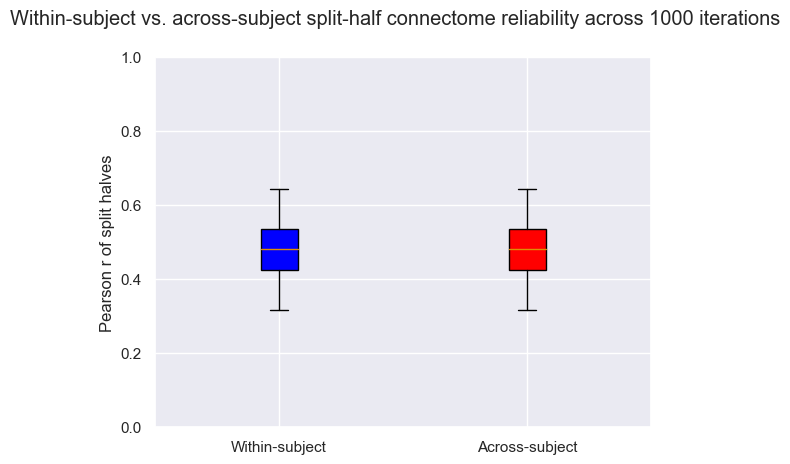

In [164]:
# plot the results

fig, ax = plt.subplots(1,1)
fig.suptitle('Within-subject vs. across-subject split-half connectome reliability across 1000 iterations')
ax.boxplot(avg_within_sub_corr, positions=[1], patch_artist=True, boxprops=dict(facecolor='blue'), labels=['Within-subject'])
ax.boxplot(avg_within_sub_corr, positions=[2], patch_artist=True, boxprops=dict(facecolor='red'), labels=['Across-subject'])
ax.set_ylabel('Pearson r of split halves')
ax.set_ylim(0,1)
plt.show()